# Libraries

In [219]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
import datetime as dt
import mplfinance 
from renkodf import Renko
from scipy.signal import lfilter
import fx # personal functions
# import MetaTrader5 as mt5

# Gathering Data

In [220]:
# collect the actual data from csv file
# filename = "C:/Users/WilliamFetzner/Documents/Trading/DAT_XLSX_EURUSD_M1_2023.xlsx"
# exported from tickstory
tickstory_11_15_22_11_14_23 = "C:/Users/WilliamFetzner/Documents/Trading/EURUSD_11_15_22_to_11_14_23.csv"
tickstory_filename = "C:/Users/WilliamFetzner/Documents/Trading/3mo_EURUSD.csv"
tickstory_latest = "C:/Users/WilliamFetzner/Documents/Trading/EURUSD_2_13_to_3_6.csv"
# filename = "C:/Users/WilliamFetzner/Documents/Trading/EURUSD1_2_10_24.csv"
# full_filename = "C:/Users/WilliamFetzner/Documents/Trading/EURUSD1.csv"
# df = pd.read_csv(filename, header=None, names=['date', 'time', 'open', 'high', 'low', 'close', 'volume'])
df_22_23 = pd.read_csv(tickstory_11_15_22_11_14_23)
df_1123_0224 = pd.read_csv(tickstory_filename)#, header=None, names=['Timestamp','Bid price','Ask price','Bid volume','Ask volume'])
df_latest = pd.read_csv(tickstory_latest)
# df_full = pd.read_csv(full_filename, header=None, names=['date', 'time', 'open', 'high', 'low', 'close', 'volume'])
print(len(df_22_23), len(df_1123_0224), len(df_latest))

30234321 6259045 1251852


In [221]:
# add the latest data to the bottom of df
df = pd.concat([df_22_23, df_1123_0224, df_latest])
# df = pd.concat([df_1123_0224, df_latest])
df = df.reset_index(drop=True)
# drop any duplicate rows
df = df.drop_duplicates()
df.tail(10)


,Timestamp,Bid price,Ask price,Bid volume,Ask volume
37745208,20240306 18:59:44:161,1.08990,1.08992,2.44,1.33
37745209,20240306 18:59:44:264,1.08990,1.08991,0.90,0.90
37745210,20240306 18:59:49:551,1.08989,1.08990,3.90,0.90
37745211,20240306 18:59:52:521,1.08989,1.08990,0.90,0.90
37745212,20240306 18:59:53:627,1.08989,1.08992,2.44,2.23
37745213,20240306 18:59:53:932,1.08991,1.08992,1.80,1.33
37745214,20240306 18:59:53:984,1.08994,1.08996,3.90,8.55
37745215,20240306 18:59:54:291,1.08995,1.08996,0.90,0.90
37745216,20240306 18:59:54:445,1.08995,1.08997,0.90,2.70
37745217,20240306 18:59:54:548,1.08995,1.08996,0.90,1.80


In [222]:
# convert date to datetime
df['datetime'] = pd.to_datetime(df['Timestamp'], format='%Y%m%d %H:%M:%S:%f')
# rename bid price to close
df.rename(columns={'Bid price':'close'}, inplace=True)
df_ready = df.set_index('datetime')
# adjust the datetime 7 hrs ahead to match market time
df_ready.index = df_ready.index + pd.Timedelta(hours=7)
# df_tick_ready_2024 = df_ready['2024-01-01':'2024-02-13']
# df_full['datetime'] = pd.to_datetime(df_full['date'] + ' ' + df_full['time'], format='%Y.%m.%d %H:%M')
# filter the data to just 2024
# df_full_2024 = fx.prep_data(df_full, 2024)
# ohlc = fx.prep_data(df, 2024)

In [223]:
ohlc = df_ready[['close']]
ohlc

,close
datetime,
2022-11-15 02:00:00.098,1.03196
2022-11-15 02:00:00.200,1.03195
2022-11-15 02:00:00.302,1.03197
2022-11-15 02:00:00.404,1.03196
2022-11-15 02:00:00.507,1.03197
...,...
2024-03-07 01:59:53.932,1.08991
2024-03-07 01:59:53.984,1.08994
2024-03-07 01:59:54.291,1.08995


# Getting Data Ready

# Exploratory Data Analysis
To make sure that the PSAR and Impulse are correctly duplicated from Pinescript to python

In [224]:
# ohlc.open.count()
# 1819/322638 old data
# 0.5% of the time it skips minutes
# and 100 of those it was skipping 2 hrs

# 89/371342
# 0.02% of the time it skips minutes
# and the largest range of skips is 3-28 minutes 
# for an avg of 7 minutes


In [225]:

# # find the difference in minutes between each row
# ohlc['diff'] = ohlc.index.to_series().diff().dt.total_seconds().div(60, fill_value=0)
# # find the difference in days between each row, place a 0 if it is the same day
# ohlc['diff_day'] = ohlc.index.to_series().diff().dt.days.fillna(0)
# # filter to where the diff is > 1 but the diff_day is 0
# ohlc_fil = ohlc.loc[(ohlc['diff'] > 1) & (ohlc['diff_day'] == 0)]
# # sort ohlc_fil by the diff column
# ohlc_fil = ohlc_fil.sort_values(by=['diff'], ascending=False)
# ohlc_fil.head(90)
# # find the avg of diff
# ohlc_fil['diff'].mean()


In [226]:
# filter ohlc to be between march 23rd 12:00 and march 23rd 19:00
# ohlc_march_23 = ohlc.loc['2023-03-23 14:00':'2023-03-23 18:00']
# ohlc_march_23

# Calculations

In [227]:
# Calculate Impulse MACD
# df_impulse = fx.calc_impulse_macd(ohlc_dec_1_day_15_min)
# df_impulse

In [228]:
# # remove all rows with null values for sh
# df_impulse_no_sh_na = df_impulse.dropna(subset=['sh'])
# # find the max and min of sh
# sh_max = df_impulse_no_sh_na['sh'].max()
# sh_min = df_impulse_no_sh_na['sh'].min()


In [229]:
# # remove all rows with null values for sb
# df_impulse_no_sb_na = df_impulse.dropna(subset=['sb'])
# # find the max and min of sb
# sb_max = df_impulse_no_sb_na['sb'].max()
# sb_min = df_impulse_no_sb_na['sb'].min()

In [230]:
# y_min = min(sh_min, sb_min)
# y_max = max(sh_max, sb_max)

In [231]:
# # find crossover points of sh and sb by seeing when the sign of 'md' goes from being > 0 to < 0, or vice versa but don't include 0
# df_impulse['md_sign'] = np.sign(df_impulse['md'])

# # crossover would be when 'md_sign' == 1 or -1 and the previous value of 'md_sign' was 0 or -1 or 1 respectively
# df_impulse['crossover'] = np.where((df_impulse['md_sign'] == 1) & ((df_impulse['md_sign'].shift(1) == 0) | (df_impulse['md_sign'].shift(1) == -1)), 1, 
#                                 np.where((df_impulse['md_sign'] == -1) & ((df_impulse['md_sign'].shift(1) == 0) | (df_impulse['md_sign'].shift(1) == 1)), -1, 0))

# # filter to just where crossover is not 0
# df_impulse_crossover = df_impulse.loc[df_impulse['crossover'] != 0]
# df_impulse_crossover

In [232]:
# # filter to between 1 am and 2 am
# df_impulse_signal_1_to_2 = df_impulse.between_time('8:30', '9:30')
# df_impulse_signal_1_to_2

In [233]:
def find_min_max(df, col):
    df_no_na = df.dropna(subset=[col])
    min = df_no_na[col].min()
    max = df_no_na[col].max()
    return min, max

In [234]:
import matplotlib.pyplot as plt

# Assuming 'df_impulse' is your DataFrame and it has been processed by 'calc_impulse_macd' function
def impulse_graph(df_impulse, col1, col2):
    sh_min, sh_max = find_min_max(df_impulse, col1)
    sb_min, sb_max = find_min_max(df_impulse, col2)
    
    y_min = min(sh_min, sb_min)
    y_max = max(sh_max, sb_max)
    # Create a new figure
    fig, ax = plt.subplots()

    # Plot the Impulse Histogram
    ax.plot(df_impulse[col1], label='ImpulseSignal', color='blue')

    # Plot the Impulse MACD CD Signal
    ax.plot(df_impulse[col2], label='ImpulseMACDSignal', color='orange')

    # change the x axis to be much smaller and go from the max of sh and sb to the min of sh and sb
    ax.set_ylim([y_min - 0.000001, y_max + 0.000001])

    # Add legend
    ax.legend()

    fig.set_size_inches(18.5, 10.5)

    # Show the plot
    plt.show()


## Plotting

In [235]:
# # Plot
# fig, ax = plt.subplots()
# mplfinance.plot(ohlc_dec_1_day_15_min, type='candle', ax=ax, volume=False, show_nontrading=False)
# # add the psar scatterplot to the chart
# plt.scatter(df_psar.index, df_psar['PSAR'], color=df_psar['Color'], lw=0.5, label='PSAR')
# ax.set_xlabel('Date')
# ax.set_ylabel('Price')
# fig.suptitle('EURUSD 12/1/2023 15-min candlestick chart w/ PSAR')
# # increase the size of the chart
# fig.set_size_inches(18.5, 10.5)

# plt.show()

## Renko Charts

In [236]:
# # create a renko chart from the ohlc_dec_1 dataframe
# r = Renko(ohlc_dec_1, brick_size=0.0003)
# # create a new dataframe from the renko features
# renko_df_ready = r.renko_df()
# renko_high = np.array(renko_df_ready['high'])
# renko_low = np.array(renko_df_ready['low'])
# renko_close = np.array(renko_df_ready['close'])
# # recalculate psar for the renko chart
# psar_renko = np.empty_like(renko_high)
# for i in range(len(renko_high)):
#    psar_renko[i] = psar_obj.calcPSAR(renko_high[i], renko_low[i])
# # Create DataFrame
# df_psar_renko = pd.DataFrame({
#    'Close': renko_close,
#    'PSAR': psar_renko,
# })
# # add a new column to the dataframe that is 'red' if the psar is above the close and 'green' if the psar is below the close
# df_psar_renko['Color'] = np.where(df_psar_renko['PSAR'] > df_psar_renko['Close'], 'red', 'green')

# # plot the renko chart
# fig, ax = plt.subplots()
# mplfinance.plot(renko_df_ready, type='candle', ax=ax, volume=False, show_nontrading=False)
# # add the psar scatterplot to the chart
# plt.scatter(df_psar_renko.index, df_psar_renko['PSAR'], color=df_psar_renko['Color'], lw=0.5, label='PSAR')
# ax.set_xlabel('Time')
# ax.set_ylabel('Price')
# fig.suptitle('EURUSD 12/4/2023 Renko chart w/ PSAR')
# # increase the size of the chart
# fig.set_size_inches(18.5, 10.5)

# plt.show()



In [237]:
# df_psar_renko.index

# Testing Data

## Parameters

In [238]:
# Renko variable
brick_size = 0.0003

# psar variables
start = 0.02
increment = 0.02
maximum = 0.2

# impulse variables
lengthMA = 34
lengthSignal = 9

# sma variables
sma_length = 3
smoothing_sma = 3

## Nova Optimized Parameters

In [239]:
# # Renko variable
# brick_size = 0.00007

# # psar variables
# start = 0.139862
# increment = 0.139862
# maximum = 0.451

# # impulse variables
# lengthMA = 10
# lengthSignal = 8

## MSolutions Optimized Parameters

In [240]:
# # Renko variable
# brick_size = 0.00091

# # psar variables
# start = 0.0385
# increment = 0.0385
# maximum = 0.34499

# # impulse variables
# lengthMA = 51
# lengthSignal = 31

In [241]:
# Lot Size
lot_size = 2
per_lot = 100000

# stop loss
stop_loss = brick_size*2

# take profit
take_profit_size = brick_size*4

# Commissions
nova_commission = lot_size * -3
msolutions_commission = lot_size * -5

# starting balance
balance = 200000

# base currency rate
base_currency_rate = 0.045 # EUR
quote_currency_rate = 0.055 # USD

## Renko charts (from 1 min data)

In [242]:
# create a renko chart from the ohlc_dec_1 dataframe
r_full = Renko(ohlc, brick_size=brick_size)
# create a new dataframe from the renko features
renko_full_data = r_full.renko_df()
# renko_full_data = fx.psar_from_data(renko_full_data, increment, maximum)
renko_full_data.tail(10)

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\renkodf\renkodf.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["datetime"] = df.index


,open,high,low,close,volume
datetime,,,,,
2024-03-06 18:55:41.960,1.0911,1.09140,1.09110,1.0914,392.0
2024-03-06 19:11:58.650,1.0911,1.09153,1.09080,1.0908,2007.0
2024-03-06 19:34:35.013,1.0908,1.09124,1.09050,1.0905,1537.0
2024-03-06 19:42:04.739,1.0905,1.09058,1.09020,1.0902,717.0
2024-03-06 21:03:54.083,1.0902,1.09077,1.08990,1.0899,5141.0
2024-03-06 21:14:54.215,1.0899,1.09008,1.08960,1.0896,1230.0
2024-03-06 22:23:07.131,1.0896,1.08988,1.08930,1.0893,3901.0
2024-03-06 22:58:31.495,1.0896,1.08990,1.08929,1.0899,1670.0
2024-03-07 00:02:40.111,1.0896,1.08995,1.08930,1.0893,1579.0


In [243]:
# save renko to csv
renko_full_data.to_csv('renko_full_data.csv')

In [254]:
# read in the renko data
renko_full_data = pd.read_csv('renko_full_data.csv')
# convert date to datetime
renko_full_data['datetime'] = pd.to_datetime(renko_full_data['datetime'], format='%Y-%m-%d %H:%M:%S.%f')
renko_full_data = renko_full_data.set_index('datetime')
renko_full_data

,open,high,low,close,volume
datetime,,,,,
2022-11-15 02:00:54.735,1.0320,1.03230,1.03200,1.0323,98.0
2022-11-15 02:53:38.825,1.0320,1.03251,1.03170,1.0317,3867.0
2022-11-15 02:55:00.154,1.0317,1.03177,1.03140,1.0314,292.0
2022-11-15 03:00:04.310,1.0317,1.03200,1.03125,1.0320,497.0
2022-11-15 03:01:27.232,1.0320,1.03230,1.03195,1.0323,166.0
...,...,...,...,...,...
2024-03-06 21:14:54.215,1.0899,1.09008,1.08960,1.0896,1230.0
2024-03-06 22:23:07.131,1.0896,1.08988,1.08930,1.0893,3901.0
2024-03-06 22:58:31.495,1.0896,1.08990,1.08929,1.0899,1670.0


In [251]:
# # Add the Impulse MACD CD Signal to the renko_full_data dataframe
# renko_full_data = fx.calc_impulse_macd(renko_full_data, lengthMA, int(lengthSignal))

# # crossover would be when 'sh_sign' == 1 or -1 and the previous value of 'sh_sign' was 0 or -1 or 1 respectively
# renko_full_data['crossover'] = np.where((renko_full_data['sh_sign'] == 1) & ((renko_full_data['sh_sign'].shift(1) == 0) | (renko_full_data['sh_sign'].shift(1) == -1)), 1, 
#                                 np.where((renko_full_data['sh_sign'] == -1) & ((renko_full_data['sh_sign'].shift(1) == 0) | (renko_full_data['sh_sign'].shift(1) == 1)), -1, 0))
# renko_full_data.tail(10)

In [255]:
# calculate the sma of the open high low, close / 4 for 3 periods
renko_full_data['ohlc4'] = (renko_full_data['close'] + renko_full_data['open'] + renko_full_data['high'] + renko_full_data['low']) / 4
renko_full_data['sma'] = renko_full_data['ohlc4'].rolling(window=sma_length).mean()
# calculate the sma of sma3 for 3 periods
renko_full_data['smoothing_sma'] = renko_full_data['sma'].rolling(window=smoothing_sma).mean()
# find the difference between sma and smoothing_sma
renko_full_data['sma_diff'] = renko_full_data['sma'] - renko_full_data['smoothing_sma']
# find the sign of the sma_diff
renko_full_data['sma_sign'] = np.sign(renko_full_data['sma_diff'])
# find where the sma_sign changes from 1 to -1 or -1 to 1
renko_full_data['sma_crossover'] = np.where((renko_full_data['sma_sign'] == 1) & (renko_full_data['sma_sign'].shift(1) == -1), 1, 
                                np.where((renko_full_data['sma_sign'] == -1) & (renko_full_data['sma_sign'].shift(1) == 1), -1, 0))
# when sma_crossover is 1 then buy, when sma_crossover is -1 then sell
renko_full_data['sma_signal'] = np.where(renko_full_data['sma_crossover'] == 1, 'buy',
                                np.where(renko_full_data['sma_crossover'] == -1, 'sell', ''))
renko_full_data

,open,high,low,close,volume,ohlc4,sma,smoothing_sma,sma_diff,sma_sign,sma_crossover,sma_signal
datetime,,,,,,,,,,,,
2022-11-15 02:00:54.735,1.0320,1.03230,1.03200,1.0323,98.0,1.032150,NaN,NaN,NaN,NaN,0,
2022-11-15 02:53:38.825,1.0320,1.03251,1.03170,1.0317,3867.0,1.031977,NaN,NaN,NaN,NaN,0,
2022-11-15 02:55:00.154,1.0317,1.03177,1.03140,1.0314,292.0,1.031567,1.031898,NaN,NaN,NaN,0,
2022-11-15 03:00:04.310,1.0317,1.03200,1.03125,1.0320,497.0,1.031737,1.031761,NaN,NaN,NaN,0,
2022-11-15 03:01:27.232,1.0320,1.03230,1.03195,1.0323,166.0,1.032137,1.031814,1.031824,-0.000010,-1.0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-06 21:14:54.215,1.0899,1.09008,1.08960,1.0896,1230.0,1.089795,1.090119,1.090430,-0.000311,-1.0,0,
2024-03-06 22:23:07.131,1.0896,1.08988,1.08930,1.0893,3901.0,1.089520,1.089836,1.090132,-0.000296,-1.0,0,
2024-03-06 22:58:31.495,1.0896,1.08990,1.08929,1.0899,1670.0,1.089672,1.089662,1.089872,-0.000210,-1.0,0,


In [256]:
# find the max of renko_full_data.index
max_index = renko_full_data.index.max() - pd.Timedelta(days=1)
# filter to just the day in the max_index
renko_full_data_max_day = renko_full_data.loc[renko_full_data.index.date == max_index.date()]
# impulse_graph(renko_full_data_max_day, 'md', 'sb')

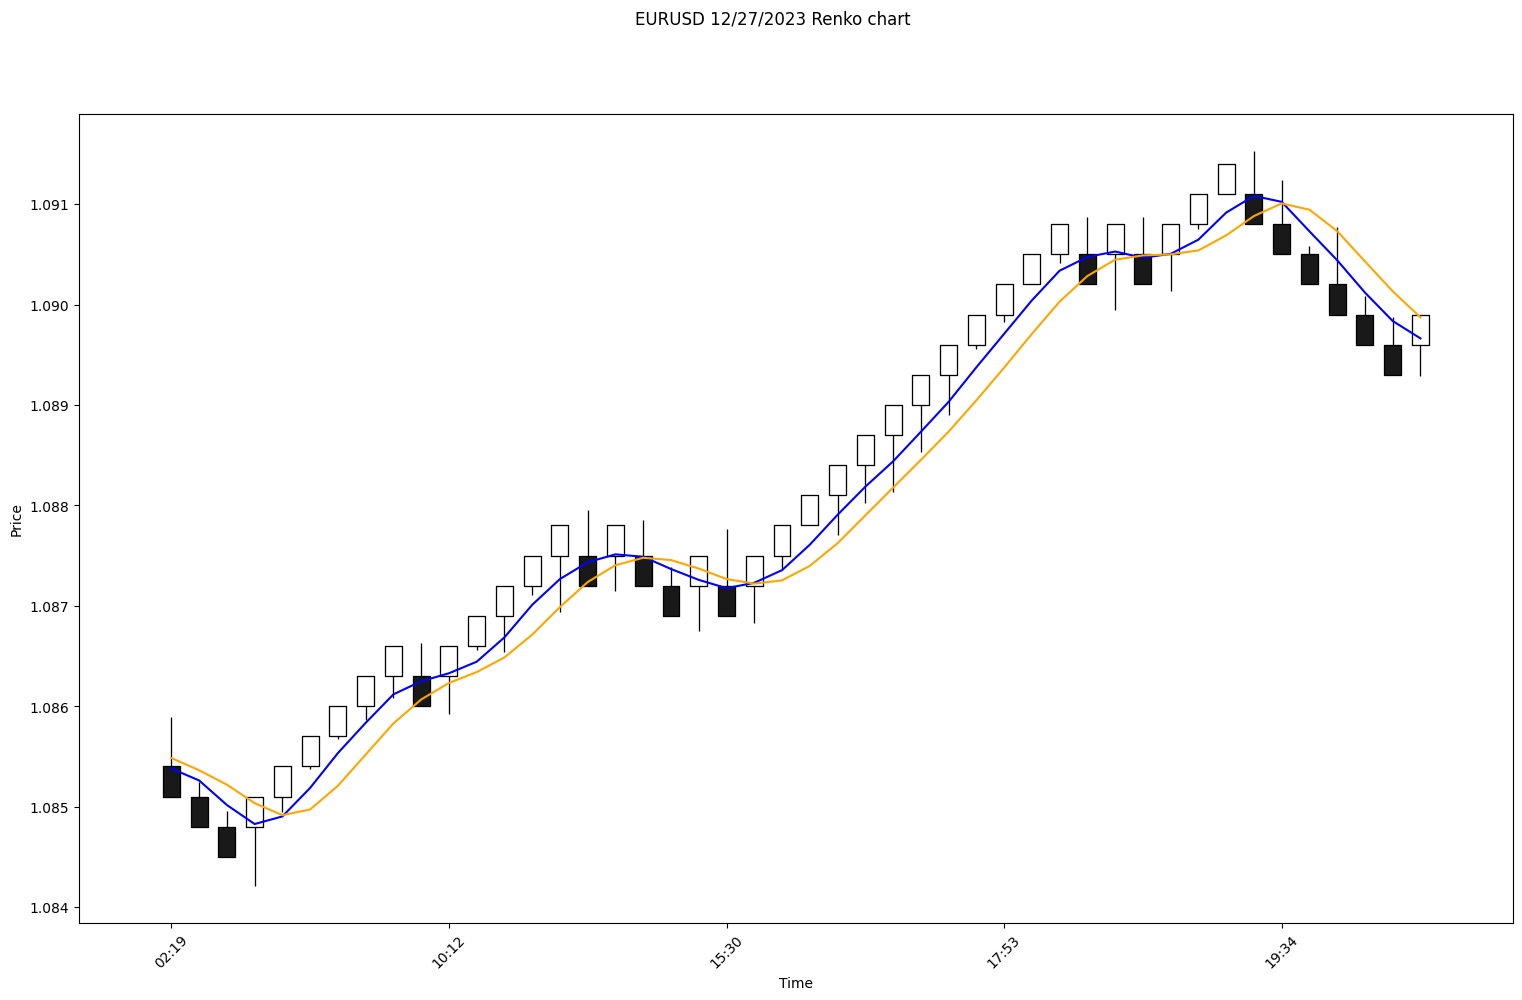

In [257]:
# plot the renko chart
fig, ax = plt.subplots()
mplfinance.plot(renko_full_data_max_day, type='candle', ax=ax, volume=False, show_nontrading=False)
renko_full_data_max_day_reset = renko_full_data_max_day.reset_index()
# add the sma and smoothing_sma to the chart
ax.plot(renko_full_data_max_day_reset.index, renko_full_data_max_day['sma'], label='SMA', color='blue')
ax.plot(renko_full_data_max_day_reset.index, renko_full_data_max_day['smoothing_sma'], label='SmoothingSMA', color='orange')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
fig.suptitle('EURUSD 12/27/2023 Renko chart')
# increase the size of the chart
fig.set_size_inches(18.5, 10.5)

plt.show()

In [258]:
# add a column to renko_full_data that will indicate the color of the renko brick based on the "open" and "close" columns of the renko_full_data dataframe, 
# if the open is greater than the close then the color is red, otherwise it is green
renko_full_data['brick_color'] = np.where(renko_full_data['open'] > renko_full_data['close'], 'red', 'green')

In [259]:
# add the day of the week to the dataframe
renko_full_data['day_of_week'] = renko_full_data.index.day_name()
# place a 1 in day_of_week_transition, if it is the last bar on Friday and the next bar is Sunday
renko_full_data['day_of_week_transition'] = np.where((renko_full_data['day_of_week'] == 'Friday') & 
                                                     ((renko_full_data['day_of_week'].shift(-1) == 'Sunday') | (renko_full_data['day_of_week'].shift(-1) == 'Monday') |
                                                      (renko_full_data['day_of_week'].shift(-1) == 'Tuesday')), 1, 0)

In [260]:
renko_full_data.columns

Index(['open', 'high', 'low', 'close', 'volume', 'ohlc4', 'sma',
       'smoothing_sma', 'sma_diff', 'sma_sign', 'sma_crossover', 'sma_signal',
       'brick_color', 'day_of_week', 'day_of_week_transition'],
      dtype='object')

## Entry conditions

In [261]:
# if the day_of_week_transition is 1 and the sma_signal is 1 then replace sma_signal with ''
renko_full_data['sma_signal'] = np.where((renko_full_data['day_of_week_transition'] == 1), 'exit', renko_full_data['sma_signal'])
# Forward fill 'exit' values up to the next 'buy' or 'sell'
mask = renko_full_data['sma_signal'].isin(['buy', 'sell'])
renko_full_data['sma_signal'] = renko_full_data['sma_signal'].where(mask | (renko_full_data['sma_signal'] == 'exit')).ffill()
renko_full_data

,open,high,low,close,volume,ohlc4,sma,smoothing_sma,sma_diff,sma_sign,sma_crossover,sma_signal,brick_color,day_of_week,day_of_week_transition
datetime,,,,,,,,,,,,,,,
2022-11-15 02:00:54.735,1.0320,1.03230,1.03200,1.0323,98.0,1.032150,NaN,NaN,NaN,NaN,0,NaN,green,Tuesday,0
2022-11-15 02:53:38.825,1.0320,1.03251,1.03170,1.0317,3867.0,1.031977,NaN,NaN,NaN,NaN,0,NaN,red,Tuesday,0
2022-11-15 02:55:00.154,1.0317,1.03177,1.03140,1.0314,292.0,1.031567,1.031898,NaN,NaN,NaN,0,NaN,red,Tuesday,0
2022-11-15 03:00:04.310,1.0317,1.03200,1.03125,1.0320,497.0,1.031737,1.031761,NaN,NaN,NaN,0,NaN,green,Tuesday,0
2022-11-15 03:01:27.232,1.0320,1.03230,1.03195,1.0323,166.0,1.032137,1.031814,1.031824,-0.000010,-1.0,0,NaN,green,Tuesday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-06 21:14:54.215,1.0899,1.09008,1.08960,1.0896,1230.0,1.089795,1.090119,1.090430,-0.000311,-1.0,0,sell,red,Wednesday,0
2024-03-06 22:23:07.131,1.0896,1.08988,1.08930,1.0893,3901.0,1.089520,1.089836,1.090132,-0.000296,-1.0,0,sell,red,Wednesday,0
2024-03-06 22:58:31.495,1.0896,1.08990,1.08929,1.0899,1670.0,1.089672,1.089662,1.089872,-0.000210,-1.0,0,sell,green,Wednesday,0


In [262]:
# def add_entry_signal(df_init, psar, impulse):
#     if 'entry_signal' not in df_init.columns:
#         # find the length of the dataframe
#         len_df = len(df_init.index)
#         # create a list of 'none' that is the same length as the dataframe
#         entry_signal_list = ['none'] * len_df
#         # create a new dataframe that has the same index as df_init and an 'entry_signal' column that is all 'none'
#         df_entry = pd.DataFrame({'entry_signal': entry_signal_list}, index=df_init.index)
#         # merge df_init with df_entry
#         df_fil = pd.merge(df_init, df_entry, left_index=True, right_index=True, how='left')

#     elif 'entry_signal' in df_init.columns:
#         # filter to just the rows where 'entry_signal' is 'none'
#         df_fil = df_init.loc[df_init['entry_signal'] == 'none']
#     print(len(df_fil.brick_color))
#     if (psar == True) & (impulse == True):
#         print('psar and impulse true')
#         df_fil['entry_signal'] = np.where((df_fil['psar_signal'] == 'buy') & (df_fil['impulse_signal'] == 'buy') & 
#                                            (df_fil['brick_color'] == 'green') & (df_fil['day_of_week_transition'] != 1), 'long', 
#                                         np.where((df_fil['psar_signal'] == 'sell') & (df_fil['impulse_signal'] == 'sell') & 
#                                                  (df_fil['brick_color'] == 'red') & (df_fil['day_of_week_transition'] != 1), 'short', 
#                                                  df_fil['entry_signal']))
#     elif (psar == True) & (impulse != True):
#         print('psar true')
#         df_fil['entry_signal'] = np.where((df_fil['psar_signal'] == 'buy') & 
#                                       (df_fil['brick_color'] == 'green') & (df_fil['day_of_week_transition'] != 1), 'long', 
#                                       np.where((df_fil['psar_signal'] == 'sell') & 
#                                                (df_fil['brick_color'] == 'red') & (df_fil['day_of_week_transition'] != 1), 'short', 
#                                                df_fil['entry_signal']))
#     elif (psar != True) & (impulse == True):
#         print('impulse true')
#         df_fil['entry_signal'] = np.where((df_fil['impulse_signal'] == 'buy') & 
#                                       (df_fil['brick_color'] == 'green') & (df_fil['day_of_week_transition'] != 1), 'long', 
#                                       np.where((df_fil['impulse_signal'] == 'sell') & 
#                                                (df_fil['brick_color'] == 'red') & (df_fil['day_of_week_transition'] != 1), 'short', 
#                                                df_fil['entry_signal']))
#     elif (psar != True) & (impulse != True):
#         print('neither true')
#         df_fil['entry_signal'] = np.where((df_fil['brick_color'] == 'green') & (df_fil['day_of_week_transition'] != 1), 'long', 
#                                       np.where((df_fil['brick_color'] == 'red') & (df_fil['day_of_week_transition'] != 1), 'short', 
#                                                df_fil['entry_signal']))
#     # count the number of 'none' values in df_init
#     # count_none = df_init['entry_signal'].eq('none').sum()
#     # print('first Init_none:', count_none)
#     # replace any 'none' values in df_init with None
#     if 'entry_signal' in df_init.columns:
#         df_init['entry_signal'] = df_init['entry_signal'].replace('none', None)
#         df_fil['entry_signal'] = df_fil['entry_signal'].replace('none', None)
#         # count the number of rows that are None in df_init
#         count_none = df_init['entry_signal'].isna().sum()
#         count_none_fil = df_fil['entry_signal'].isna().sum()
#         print('Init_none:', count_none)
#         print('Fil_none:', count_none_fil)
#         # combine df_fil with df_init
#         df = df_init.combine_first(df_fil)
#         # replace any None values in df with 'none'
#         df['entry_signal'] = df['entry_signal'].replace([None], 'none')
#         return df
#     else:
#         return df_fil

    

In [263]:
# def add_entry_prefix(df):
#     df['entry_signal'] = np.where(((df['entry_signal'] != 'none') & (df['entry_signal'].shift(1) == 'none')) |
#                                            ((df['entry_signal'] == 'long') & (df['entry_signal'].shift(1) == 'short')) |
#                                            ((df['entry_signal'] == 'short') & (df['entry_signal'].shift(1) == 'long')),
#                                             'entry + ' + df['entry_signal'], df['entry_signal'])
#     return df

In [264]:
def add_tp_sl(df, take_profit, stop_loss):
    df['take_profit'] = np.where(df['sma_signal'] == 'buy', df['open'] + take_profit, 
                                 np.where(df['sma_signal'] == 'sell', df['open'] - take_profit, np.nan))
    df['stop_loss'] = np.where(df['sma_signal'] == 'buy', df['open'] - stop_loss, 
                                 np.where(df['sma_signal'] == 'sell', df['open'] + stop_loss, np.nan))
    return df

In [265]:
add_tp_sl(renko_full_data, take_profit_size, stop_loss)
renko_full_data
# # filter renko_entry_added to where the entry_signal includes "entry"
# renko_entry_added_entry = renko_entry_added.loc[renko_entry_added['entry_signal'].str.contains('entry', na=False)]
# # select just the entry_signal, open, take_profit, and stop_loss columns
# renko_entry_added_entry[['entry_signal', 'open', 'take_profit', 'stop_loss']]

,open,high,low,close,volume,ohlc4,sma,smoothing_sma,sma_diff,sma_sign,sma_crossover,sma_signal,brick_color,day_of_week,day_of_week_transition,take_profit,stop_loss
datetime,,,,,,,,,,,,,,,,,
2022-11-15 02:00:54.735,1.0320,1.03230,1.03200,1.0323,98.0,1.032150,NaN,NaN,NaN,NaN,0,NaN,green,Tuesday,0,NaN,NaN
2022-11-15 02:53:38.825,1.0320,1.03251,1.03170,1.0317,3867.0,1.031977,NaN,NaN,NaN,NaN,0,NaN,red,Tuesday,0,NaN,NaN
2022-11-15 02:55:00.154,1.0317,1.03177,1.03140,1.0314,292.0,1.031567,1.031898,NaN,NaN,NaN,0,NaN,red,Tuesday,0,NaN,NaN
2022-11-15 03:00:04.310,1.0317,1.03200,1.03125,1.0320,497.0,1.031737,1.031761,NaN,NaN,NaN,0,NaN,green,Tuesday,0,NaN,NaN
2022-11-15 03:01:27.232,1.0320,1.03230,1.03195,1.0323,166.0,1.032137,1.031814,1.031824,-0.000010,-1.0,0,NaN,green,Tuesday,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-06 21:14:54.215,1.0899,1.09008,1.08960,1.0896,1230.0,1.089795,1.090119,1.090430,-0.000311,-1.0,0,sell,red,Wednesday,0,1.0887,1.0905
2024-03-06 22:23:07.131,1.0896,1.08988,1.08930,1.0893,3901.0,1.089520,1.089836,1.090132,-0.000296,-1.0,0,sell,red,Wednesday,0,1.0884,1.0902
2024-03-06 22:58:31.495,1.0896,1.08990,1.08929,1.0899,1670.0,1.089672,1.089662,1.089872,-0.000210,-1.0,0,sell,green,Wednesday,0,1.0884,1.0902


In [266]:
# def add_exit_signal(df):
#     df['entry_signal'] = np.where((df['entry_signal'].shift(1) == 'entry + short') & (df['entry_signal'] != 'short'), 'exit', 
#                                             np.where((df['entry_signal'].shift(1) == 'short') & (df['entry_signal'] != 'short'), 'exit', 
#                                                      np.where((df['entry_signal'].shift(1) == 'entry + long') & (df['entry_signal'] != 'long'), 'exit', 
#                                                               np.where((df['entry_signal'].shift(1) == 'long') & (df['entry_signal'] != 'long'), 'exit', 
#                                                                        df['entry_signal']))))
#     return df

In [267]:
def cum_count(df):
    # position_count will be a cumulative count used to filter the data to the timeframe between the entry 
    # and exit signals so anytime there is an "entry + buy" or "entry + short" the count should increase by 1
    df['position_count'] = np.where(df['sma_crossover'] == 1, 1, np.where(df['sma_crossover'] == -1, 1,0))
    df['cum_position_count'] = df['position_count'].cumsum()
    # if day_of_week_transition is 1 then make the cum_position_count null
    df['cum_position_count'] = np.where(df['sma_signal'] == 'exit', None, df['cum_position_count'])
    return df

cum_count(renko_full_data)

,open,high,low,close,volume,ohlc4,sma,smoothing_sma,sma_diff,sma_sign,sma_crossover,sma_signal,brick_color,day_of_week,day_of_week_transition,take_profit,stop_loss,position_count,cum_position_count
datetime,,,,,,,,,,,,,,,,,,,
2022-11-15 02:00:54.735,1.0320,1.03230,1.03200,1.0323,98.0,1.032150,NaN,NaN,NaN,NaN,0,NaN,green,Tuesday,0,NaN,NaN,0,0
2022-11-15 02:53:38.825,1.0320,1.03251,1.03170,1.0317,3867.0,1.031977,NaN,NaN,NaN,NaN,0,NaN,red,Tuesday,0,NaN,NaN,0,0
2022-11-15 02:55:00.154,1.0317,1.03177,1.03140,1.0314,292.0,1.031567,1.031898,NaN,NaN,NaN,0,NaN,red,Tuesday,0,NaN,NaN,0,0
2022-11-15 03:00:04.310,1.0317,1.03200,1.03125,1.0320,497.0,1.031737,1.031761,NaN,NaN,NaN,0,NaN,green,Tuesday,0,NaN,NaN,0,0
2022-11-15 03:01:27.232,1.0320,1.03230,1.03195,1.0323,166.0,1.032137,1.031814,1.031824,-0.000010,-1.0,0,NaN,green,Tuesday,0,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-06 21:14:54.215,1.0899,1.09008,1.08960,1.0896,1230.0,1.089795,1.090119,1.090430,-0.000311,-1.0,0,sell,red,Wednesday,0,1.0887,1.0905,0,8100
2024-03-06 22:23:07.131,1.0896,1.08988,1.08930,1.0893,3901.0,1.089520,1.089836,1.090132,-0.000296,-1.0,0,sell,red,Wednesday,0,1.0884,1.0902,0,8100
2024-03-06 22:58:31.495,1.0896,1.08990,1.08929,1.0899,1670.0,1.089672,1.089662,1.089872,-0.000210,-1.0,0,sell,green,Wednesday,0,1.0884,1.0902,0,8100


In [268]:
# def sl_tp_exits(df):
#     changed = 0
#     # group by cum_position_count and forward fill the value in the first index of the 'stop_loss' column
#     df['stop_loss'] = df.groupby('cum_position_count')['stop_loss'].ffill()
#     df['take_profit'] = df.groupby('cum_position_count')['take_profit'].ffill()

#     # determine whether the exit should be sooner because the stop_loss was hit before the exit signal (look at the high/low of the brick)
#     df['exit_stop_loss'] = np.where((df['entry_signal'] == 'long') & (df['stop_loss'] > df['low']), 1,
#                                             np.where((df['entry_signal'] == 'short') & (df['stop_loss'] < df['high']), 1, 0))
#     df['exit_take_profit'] = np.where((df['entry_signal'] == 'long') & (df['take_profit'] < df['high']), 1,
#                                             np.where((df['entry_signal'] == 'short') & (df['take_profit'] > df['low']), 1, 0))
#     # if there is a 1 in exit_stop_loss or exit_take_profit then set changed to 1
#     if (df['exit_stop_loss'] == 1).any() or (df['exit_take_profit'] == 1).any():
#         # get the sum of exit_stop_loss and exit_take_profit
#         print(df.exit_stop_loss.sum(), df.exit_take_profit.sum())
#         changed = 1
#     df['exit_stop_loss'] = df.groupby('cum_position_count')['exit_stop_loss'].ffill()
#     df['exit_take_profit'] = df.groupby('cum_position_count')['exit_take_profit'].ffill()
#     # if entry signal isn't 'none' and exit_stop_loss or exit_take_profit is 1 then the entry signal should be 'none'
#     df['entry_signal'] = np.where(((df['entry_signal'] != 'none') & 
#                                                 ((df['exit_stop_loss'] == 1) | (df['exit_take_profit'] == 1))), 
#                                                 'none', 
#                                                 df['entry_signal'])
#     return df, changed

In [269]:
# add a column that will be the entry signal for the strategy to be when both impulse_signal and psar_signal are both 'buy' or 'short'
# renko_entry_added = add_entry_signal(renko_full_data, True, True)

# # if there was a change from 'none' to 'buy' or 'short' then that is an entry signal and replace the 'buy' or 'short' with 'entry + buy' or 'entry + short'
# add_entry_prefix(renko_entry_added)

# # add a stop loss column that will be the entry price +/- the brick size for when the entry signal is 'entry + buy' or 'entry + short'
# add_tp_sl(renko_entry_added, take_profit_size, stop_loss)

# # if the 'entry_signal' colummn goes from 'entry + short' or 'short' to 'none' then 'none' should be replaced with 'exit' in the entry_signal column
# renko_w_exits = add_exit_signal(renko_w_stop_loss)

# # add cumulative count columns
# renko_cum_count = cum_count(renko_w_exits)

# # see if exits should be sooner with stop_loss and take_profit then repeat above steps
# df_changed = 1
# iteration = 0
# while df_changed == 1:
#     renko_entry_added, df_changed = sl_tp_exits(renko_entry_added)
#     # add a column that will be the entry signal for the strategy to be when both impulse_signal and psar_signal are both 'buy' or 'short'
#     renko_entry_added = add_entry_signal(renko_entry_added, True, True)

#     # if there was a change from 'none' to 'buy' or 'short' then that is an entry signal and replace the 'buy' or 'short' with 'entry + buy' or 'entry + short'
#     renko_entry_added = add_entry_prefix(renko_entry_added)

#     # add a stop loss column that will be the entry price +/- the brick size for when the entry signal is 'entry + buy' or 'entry + short'
#     renko_entry_added = add_tp_sl(renko_entry_added, take_profit_size, stop_loss)

#     # if the 'entry_signal' colummn goes from 'entry + short' or 'short' to 'none' then 'none' should be replaced with 'exit' in the entry_signal column
#     renko_entry_added = add_exit_signal(renko_entry_added)

#     # add cumulative count columns
#     renko_entry_added = cum_count(renko_entry_added)
    
#     iteration += 1
    
#     print('iteration:', iteration)


In [270]:
# # add a new column to the dataframe that is 'red' if the psar is above the close and 'green' if the psar is below the close
# renko_full_data['color'] = np.where(renko_full_data['psar'] > renko_full_data['close'], 'red', 'green')
# renko_df_one_day = renko_full_data.loc[renko_full_data.index.date == dt.datetime(2024, 2, 5).date()]
# # reset the index of the dataframe
# # psar_one_day = renko_df_one_day.reset_index()
# # make a column of just the count
# renko_df_one_day['count'] = range(1, len(renko_df_one_day.open) + 1)
# # renko_df_one_day

In [271]:
# renko_df_one_day.loc[:,['high','open', 'close', 'low', 'psar', 'md', 'sb', 'psar_signal', 'impulse_signal']].head(25)

In [272]:
# # plot the renko chart
# fig, ax = plt.subplots()
# mplfinance.plot(renko_df_one_day, type='candle', ax=ax, volume=False, show_nontrading=False)
# # add the psar scatterplot to the chart
# plt.scatter(renko_df_one_day['count'], renko_df_one_day['psar'], color=renko_df_one_day['color'], lw=0.5, label='PSAR')
# ax.set_xlabel('Time')
# ax.set_ylabel('Price')
# fig.suptitle('EURUSD 2/5/2023 Renko chart w/ PSAR')
# # increase the size of the chart
# fig.set_size_inches(18.5, 10.5)

# plt.show()

In [273]:
# impulse_graph(renko_df_one_day, 'md', 'sb')

In [274]:
# maybe implement this later - right now, let's keep the SL where it is

# # if first_TP_hit is 1 then the stop_loss should be set to the entry close price for that position so we need to group by the cum_position_count
# renko_full_data['stop_loss'] = np.where(renko_full_data['first_TP_hit'] == 1, renko_full_data.groupby('cum_position_count')['close'].transform('first'), renko_full_data['stop_loss'])
# # drop 'stop_loss_test'
# renko_full_data.drop(columns=['stop_loss_test'], inplace=True)
# redetermine whether the new stop_loss was hit after we took the first TP
# renko_full_data['exit_stop_loss'] = np.where((renko_full_data['entry_signal'] == 'buy') & (renko_full_data['stop_loss'] > renko_full_data['low']), 1,
#                                         np.where((renko_full_data['entry_signal'] == 'short') & (renko_full_data['stop_loss'] < renko_full_data['high']), 1, 0))
# renko_full_data.loc[renko_full_data['exit_stop_loss'] == 1]
# happens 908/2371 = 40% of the time

In [275]:
renko_full_data.loc[:,['high','open', 'close', 'low', 'sma_signal', 'stop_loss', 'cum_position_count']].tail(25)

,high,open,close,low,sma_signal,stop_loss,cum_position_count
datetime,,,,,,,
2024-03-06 15:41:19.882,1.08810,1.0878,1.0881,1.08780,buy,1.0872,8097
2024-03-06 15:50:27.186,1.08840,1.0881,1.0884,1.08770,buy,1.0875,8097
2024-03-06 16:01:11.019,1.08870,1.0884,1.0887,1.08802,buy,1.0878,8097
2024-03-06 17:17:00.022,1.08900,1.0887,1.0890,1.08813,buy,1.0881,8097
2024-03-06 17:34:44.592,1.08930,1.0890,1.0893,1.08853,buy,1.0884,8097
2024-03-06 17:42:58.955,1.08960,1.0893,1.0896,1.08890,buy,1.0887,8097
2024-03-06 17:50:16.572,1.08990,1.0896,1.0899,1.08956,buy,1.0890,8097
2024-03-06 17:53:55.394,1.09020,1.0899,1.0902,1.08983,buy,1.0893,8097
2024-03-06 17:54:56.256,1.09050,1.0902,1.0905,1.09020,buy,1.0896,8097


## Find the P/L

In [276]:
profit_df = pd.DataFrame() #columns=['cum_position_count', 'direction', 'entry_price', 'exit_price', 'first_TP_hit', 'profit']
# calculate the profit for each position by first grouping by each position and finding the entry price
profit_df['entry_price'] = renko_full_data.groupby('cum_position_count')['close'].first()
# separate out the datetime column
renko_full_data['datetime'] = renko_full_data.index
profit_df['entry_time'] = renko_full_data.groupby('cum_position_count')['datetime'].first()
profit_df['exit_time'] = renko_full_data.groupby('cum_position_count')['datetime'].last()
# # determine the exit price
profit_df['exit_price'] = renko_full_data.groupby('cum_position_count')['close'].last()

# # what was the direction, buy or short?
profit_df['direction'] = renko_full_data.groupby('cum_position_count')['sma_signal'].first()
# profit_df['direction'] = profit_df['direction'].str.split('+').str[1]

# what if I didn't take the first TP?
profit_df['profit'] = np.where((profit_df['direction'].str.strip() == 'buy'),
                                            (profit_df['exit_price'] - profit_df['entry_price'])*per_lot*(lot_size), 
                                            np.where((profit_df['direction'].str.strip() == 'sell'),
                                                    (profit_df['entry_price'] - profit_df['exit_price'])*per_lot*(lot_size), np.nan))

### Swap Rates

In [277]:
# find the positions where the period in between the entry_time and exit_time include 5:00 pm 
profit_df = fx.add_swap_rates(profit_df, base_currency_rate, quote_currency_rate, lots=lot_size)
profit_df

,entry_price,entry_time,exit_time,exit_price,direction,profit,swap,swap_rate
cum_position_count,,,,,,,,
0,1.0323,2022-11-15 02:00:54.735,2022-11-15 03:01:27.232,1.0323,None,NaN,0,0.000000
1,1.0317,2022-11-15 03:05:56.932,2022-11-15 03:34:36.218,1.0317,buy,0.0,0,0.000000
2,1.0314,2022-11-15 03:44:59.855,2022-11-15 03:53:09.192,1.0323,sell,-180.0,0,0.000000
3,1.0317,2022-11-15 04:00:07.962,2022-11-15 04:32:48.493,1.0326,buy,180.0,0,0.000000
4,1.0320,2022-11-15 04:45:59.278,2022-11-15 05:45:48.428,1.0320,sell,0.0,0,0.000000
...,...,...,...,...,...,...,...,...
8097,1.0875,2024-03-06 15:34:36.421,2024-03-06 18:30:59.020,1.0908,buy,660.0,1,-5.023333
8098,1.0902,2024-03-06 18:35:12.104,2024-03-06 18:35:12.104,1.0902,sell,0.0,0,0.000000
8099,1.0908,2024-03-06 18:44:57.979,2024-03-06 19:34:35.013,1.0905,buy,-60.0,0,0.000000


In [278]:
# filter to just the locations where the swap rate is 1
profit_df.loc[profit_df['swap'] == 1]

,entry_price,entry_time,exit_time,exit_price,direction,profit,swap,swap_rate
cum_position_count,,,,,,,,
55,1.0392,2022-11-15 16:49:54.700,2022-11-15 17:01:21.367,1.0395,buy,60.0,1,-5.271238
157,1.0383,2022-11-16 16:58:02.261,2022-11-16 17:01:38.101,1.0386,buy,60.0,1,-5.275806
206,1.0335,2022-11-17 16:53:54.450,2022-11-17 17:13:26.839,1.0335,sell,0.0,1,5.301840
243,1.0377,2022-11-18 15:31:48.699,2022-11-18 17:09:23.155,1.0335,sell,840.0,1,5.301840
289,1.0254,2022-11-21 16:56:00.236,2022-11-21 17:07:09.997,1.0254,buy,0.0,1,-5.343722
...,...,...,...,...,...,...,...,...
8047,1.0830,2024-02-28 16:46:21.043,2024-02-28 19:40:04.914,1.0836,buy,120.0,1,-5.056711
8072,1.0806,2024-03-01 16:45:05.452,2024-03-01 17:00:00.221,1.0806,sell,0.0,1,5.070750
8085,1.0854,2024-03-04 16:41:34.371,2024-03-04 18:37:40.839,1.0857,buy,60.0,1,-5.046930


In [279]:
# no initial TP
profit_df['nova_profit'] = profit_df['profit'] + nova_commission + profit_df['swap_rate']
profit_df['msolutions_profit'] = profit_df['profit'] + msolutions_commission + profit_df['swap_rate']

In [280]:
# find the entry day of the week
profit_df['entry_day_of_week'] = profit_df['entry_time'].dt.day_name()
profit_df['exit_day_of_week'] = profit_df['exit_time'].dt.day_name()

# filter to just those entries on Friday
profit_df_friday = profit_df.loc[profit_df['entry_day_of_week'] == 'Friday']
# find where entry and exit day of the week are different
profit_df_friday['entry_exit_day_of_week'] = np.where(profit_df_friday['entry_day_of_week'] != profit_df_friday['exit_day_of_week'], 1, 0)
# find the number of times the entry and exit day of the week are different
weekend_hold = profit_df_friday.loc[profit_df_friday['entry_exit_day_of_week'] == 1]
weekend_hold

C:\Users\WilliamFetzner\AppData\Local\Temp\ipykernel_34196\2876058505.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profit_df_friday['entry_exit_day_of_week'] = np.where(profit_df_friday['entry_day_of_week'] != profit_df_friday['exit_day_of_week'], 1, 0)


,entry_price,entry_time,exit_time,exit_price,direction,profit,swap,swap_rate,nova_profit,msolutions_profit,entry_day_of_week,exit_day_of_week,entry_exit_day_of_week
cum_position_count,,,,,,,,,,,,,


## Daily Drawdown

In [281]:
# use the entry time and resample to each day and find the sum of the profit
profit_df['entry_time'] = pd.to_datetime(profit_df['entry_time'])
profit_df_new_index = profit_df.set_index('entry_time')
# find the sum of the nova and msolutions profit for each day
profit_df_daily = profit_df_new_index.resample('D').agg({'nova_profit': 'sum', 'msolutions_profit': 'sum'})
# drop the weekends by first adding in a new day of the week column
profit_df_daily['day_of_week'] = profit_df_daily.index.day_name()
# drop any day that is Saturday or Sunday
profit_df_daily = profit_df_daily.loc[(profit_df_daily['day_of_week'] != 'Saturday') & (profit_df_daily['day_of_week'] != 'Sunday')]
# profit_df_daily.head(10)
# find the min of nova_profit and msolutions_profit
nova_min = profit_df_daily['nova_profit'].min()
msolutions_min = profit_df_daily['msolutions_profit'].min()
# find the days when nova_profit equals nova_min
profit_df_daily.loc[profit_df_daily['nova_profit'] == nova_min]
# 2023-01-11	nova: -4572.5	msolutions: -4912.5

,nova_profit,msolutions_profit,day_of_week
entry_time,,,
2023-01-02,-2046.862211,-2374.862211,Monday


# End Values (Total Profit, Days in Drawdown)

In [282]:
# find the number of times that profit_df_daily is below zero
profit_df_daily['nova_negative'] = np.where(profit_df_daily['nova_profit'] < 0, 1, 0)
# find the sum of nova_negative and msolutions_negative
nova_negative_sum = profit_df_daily['nova_negative'].sum()
total_days = len(profit_df_daily.index)
total_profit = profit_df['nova_profit'].sum()
print(nova_negative_sum, total_days, nova_negative_sum/total_days, '${:,.2f}'.format(total_profit))

66 343 0.1924198250728863 $290,099.60


## Summation and Plotting

In [283]:
# use the entry time and resample to each day and find the sum of the profit
profit_df['entry_time'] = pd.to_datetime(profit_df['entry_time'])
profit_df_new_index = profit_df.set_index('entry_time')
# find the sum of the nova and msolutions profit for each week
profit_df_weekly = profit_df_new_index.resample('W').agg({'nova_profit': 'sum', 'msolutions_profit': 'sum'})
# fill the null values with 0
profit_df_weekly.fillna(0, inplace=True)
# find the min, max, and mean of nova_profit and msolutions_profit
nova_min = profit_df_weekly['nova_profit'].min()
msolutions_min = profit_df_weekly['msolutions_profit'].min()
nova_max = profit_df_weekly['nova_profit'].max()
msolutions_max = profit_df_weekly['msolutions_profit'].max()
nova_mean = profit_df_weekly['nova_profit'].mean()
msolutions_mean = profit_df_weekly['msolutions_profit'].mean()
print('nova_min: ', nova_min, 'msolutions_min: ', msolutions_min, 'nova_max: ', nova_max, 'msolutions_max: ', msolutions_max, 'nova_mean: ', nova_mean, 'msolutions_mean: ', msolutions_mean)
# nova_min:  -3582.50 msolutions_min:  -4562.50 nova_max:  25144.99 msolutions_max:  23924.99 nova_mean:  6074.66 msolutions_mean:  5179.95

nova_min:  -1029.9295016201063 msolutions_min:  -1785.9295016201063 nova_max:  14213.269210520173 msolutions_max:  13125.269210520173 nova_mean:  4204.34207613422 msolutions_mean:  3735.530481931322


In [284]:
# export profit_df to a csv file
# profit_df.to_csv('C:/Users/WilliamFetzner/Documents/Trading/profit_df_new.csv')

In [285]:
# filter profit_df_weekly to just september 
# profit_df_weekly.loc['2023-09']

In [286]:
# use the entry time and resample to each day and find the sum of the profit
profit_df['entry_time'] = pd.to_datetime(profit_df['entry_time'])
profit_df_new_index = profit_df.set_index('entry_time')
# find the sum of the nova and msolutions profit for each month
profit_df_monthly = profit_df_new_index.resample('M').agg({'nova_profit': 'sum', 'msolutions_profit': 'sum'})
# fill the null values with 0
profit_df_monthly.fillna(0, inplace=True)
# find the min, max, and mean of nova_profit
nova_min = profit_df_monthly['nova_profit'].min()
nova_max = profit_df_monthly['nova_profit'].max()
nova_mean = profit_df_monthly['nova_profit'].mean()
print('nova_min: ', nova_min, 'nova_max: ', nova_max, 'nova_mean: ', nova_mean)
# find where the nova_profit is equal to the nova_min
profit_df_monthly.loc[profit_df_monthly['nova_profit'] == nova_min]
# nova_min:  -1325.000000115916 nova_max:  54662.50002552408 nova_mean:  26829.791681260333

C:\Users\WilliamFetzner\AppData\Local\Temp\ipykernel_34196\1138230803.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  profit_df_monthly = profit_df_new_index.resample('M').agg({'nova_profit': 'sum', 'msolutions_profit': 'sum'})


nova_min:  1380.0502069224328 nova_max:  33483.64548574647 nova_mean:  17064.68254430949


,nova_profit,msolutions_profit
entry_time,,
2024-03-31,1380.050207,1220.050207


In [287]:
profit_df_monthly

,nova_profit,msolutions_profit
entry_time,,
2022-11-30,14737.371006,12369.371006
2022-12-31,33483.645486,30035.645486
2023-01-31,19215.184229,15775.184229
2023-02-28,22349.826227,19929.826227
2023-03-31,20097.954154,16729.954154
2023-04-30,22693.162526,21265.162526
2023-05-31,16525.539072,14765.539072
2023-06-30,14801.032359,13385.032359
2023-07-31,19233.451902,17565.451902


In [288]:
# find the end balance for nova profit and msolutions profit by summing the profits and adding to the starting balance
nova_end_balance = balance + profit_df['nova_profit'].sum()
# convert to dollars
nova_end_balance_dollars = '${:,.2f}'.format(nova_end_balance)
msolutions_end_balance = balance + profit_df['msolutions_profit'].sum()
msolutions_end_balance_dollars = '${:,.2f}'.format(msolutions_end_balance)
print(f'Nova End Balance: {nova_end_balance_dollars}')
print(f'MSolutions End Balance: {msolutions_end_balance_dollars}')
# with initial TP
# Nova End Balance: $521,957.50
# MSolutions End Balance: $474,537.50

Nova End Balance: $490,099.60
MSolutions End Balance: $457,751.60


In [289]:
total_take_home = ((nova_end_balance-balance)*.8 )+ ((msolutions_end_balance-balance)*.75)
print(total_take_home)
# with initial TP
# 463469.12

425393.3850425548


In [290]:
100000/(total_take_home/52)

12.223979457225953

In [291]:
# calculate the win rate for nova
nova_win_rate = profit_df.loc[profit_df['nova_profit'] > 0].shape[0] / profit_df.shape[0]
msolutions_win_rate = profit_df.loc[profit_df['msolutions_profit'] > 0].shape[0] / profit_df.shape[0]
# find the number of times that initial TP was hit and then the 
print('Nova Win Rate: ', nova_win_rate, 'MSolutions Win Rate: ', msolutions_win_rate)


Nova Win Rate:  0.39020771513353114 MSolutions Win Rate:  0.39020771513353114


In [292]:
# find the min for nova_profit and msolutions_profit
nova_min = profit_df['nova_profit'].min()
msolutions_min = profit_df['msolutions_profit'].min()
print(f'Nova Min: ${nova_min}')
print(f'MSolutions Min: ${msolutions_min}')
# find the max for nova_profit and msolutions_profit
nova_max = profit_df['nova_profit'].max()
msolutions_max = profit_df['msolutions_profit'].max()
print(f'Nova Max: ${nova_max}')
print(f'MSolutions Max: ${msolutions_max}')



Nova Min: $-1145.9999999998745
MSolutions Min: $-1149.9999999998745
Nova Max: $1973.999999999782
MSolutions Max: $1969.999999999782


In [293]:
# average RR ratio
# find the average RR ratio for nova_profit and msolutions_profit
# find the average profit for trades that were positive for nova_profit
nova_avg_profit = profit_df.loc[profit_df['nova_profit'] > 0]['nova_profit'].mean()
# find the average profit for trades that were negative for nova_profit
nova_avg_loss = profit_df.loc[profit_df['nova_profit'] < 0]['nova_profit'].mean()
nova_avg_profit/abs(nova_avg_loss)

2.6407055994504853

In [294]:
# create a new column for cum_sum of nova_profit and msolutions_profit
profit_df['nova_cum_sum'] = profit_df['nova_profit'].cumsum()
profit_df['msolutions_cum_sum'] = profit_df['msolutions_profit'].cumsum()

In [295]:
# find the min of nova_cum_sum
nova_min_cum_sum_min = profit_df['nova_cum_sum'].min()
nova_min_cum_sum_min

-191.99999999993577

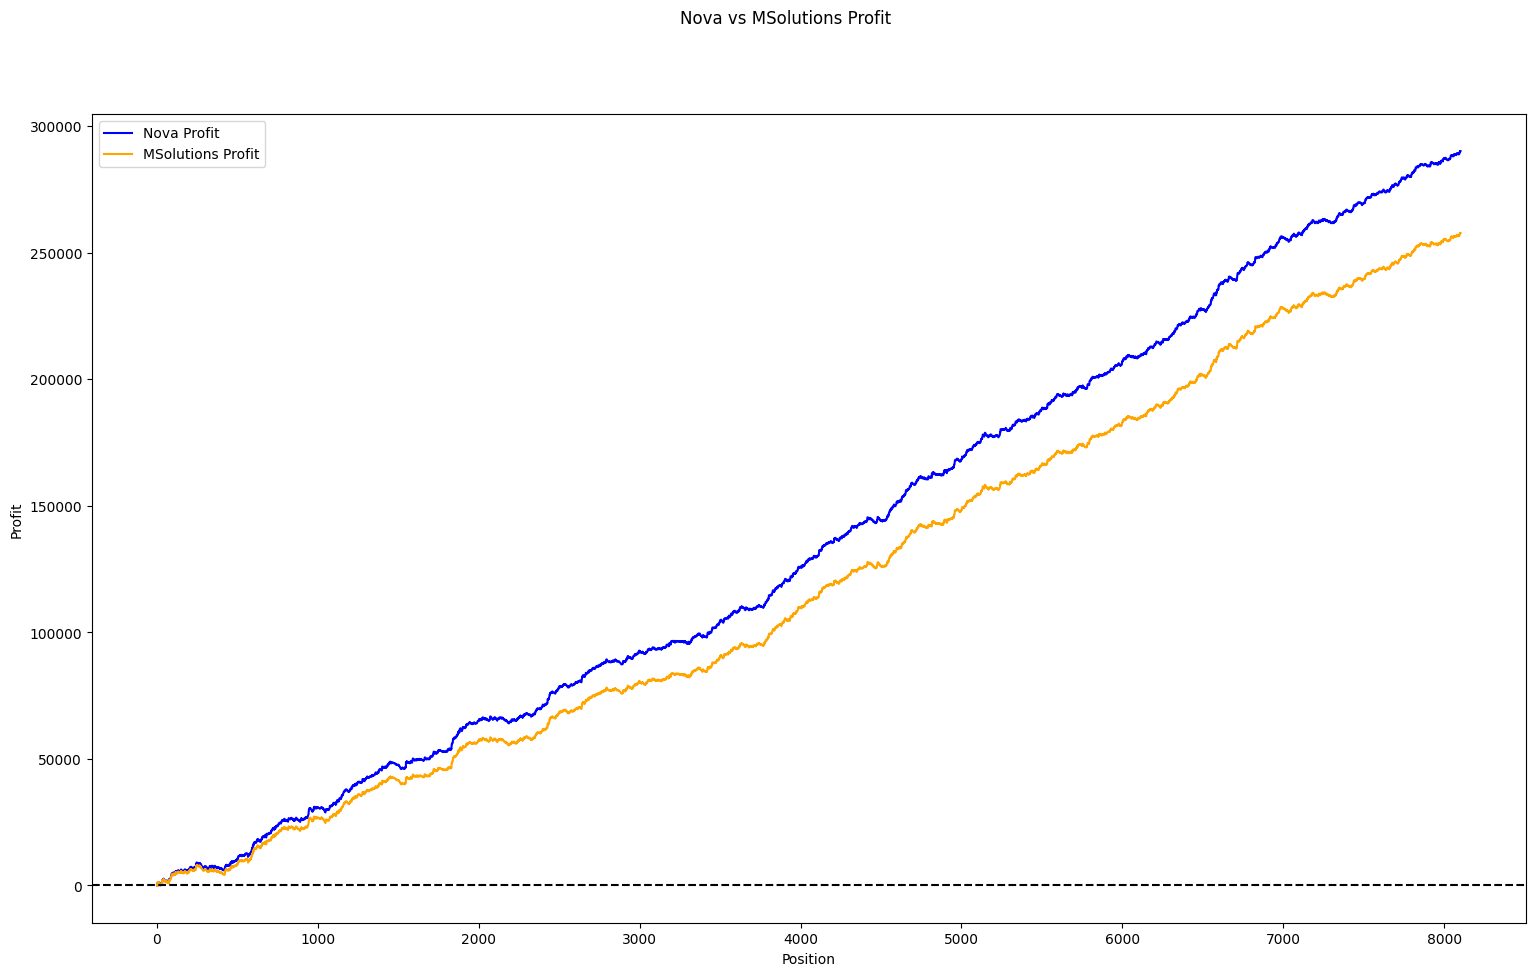

In [296]:
# graph nova_profit_dollars and msolutions_profit_dollars over cum_position_count
fig, ax = plt.subplots()
ax.plot(profit_df['nova_cum_sum'], label='Nova Profit', color='blue')
ax.plot(profit_df['msolutions_cum_sum'], label='MSolutions Profit', color='orange')
# add in a line for 0 
ax.axhline(y=0, color='black', linestyle='--')
ax.set_xlabel('Position')
ax.set_ylabel('Profit')
fig.suptitle('Nova vs MSolutions Profit')
# increase the size of the chart
fig.set_size_inches(18.5, 10.5)
# Add legend
ax.legend()
# Show the plot
plt.show()


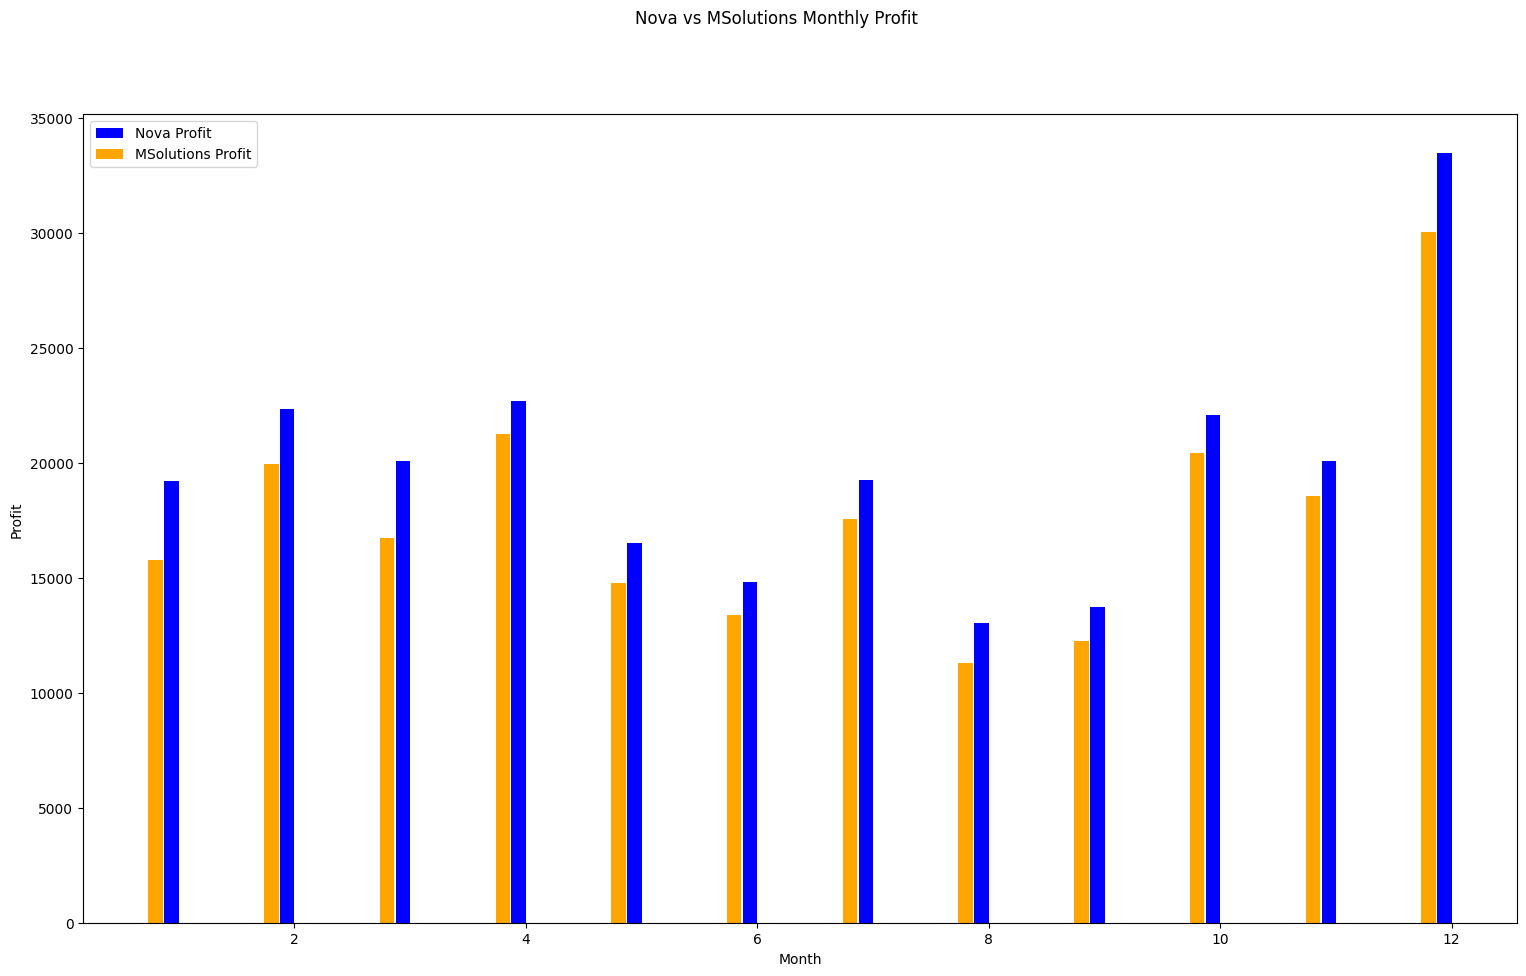

In [297]:
fig, ax = plt.subplots()
width = 0.5

# convert the index to an integer
profit_df_monthly['month'] = profit_df_monthly.index.month
# add a column for the month name
profit_df_monthly['month_name'] = profit_df_monthly.index.strftime('%B')
# profit_df_monthly

# Nova Profit
ax.bar(profit_df_monthly.month - width/8, profit_df_monthly['nova_profit'], label='Nova Profit', color='blue', width=width/4)

# MSolutions Profit
ax.bar(profit_df_monthly.month - width/2.5, profit_df_monthly['msolutions_profit'], label='MSolutions Profit', color='orange', width=width/4)

# set the x axis to be the month name
# ax.set_xticks(profit_df_monthly.month_name)

ax.set_xlabel('Month')
ax.set_ylabel('Profit')
fig.suptitle('Nova vs MSolutions Monthly Profit')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()


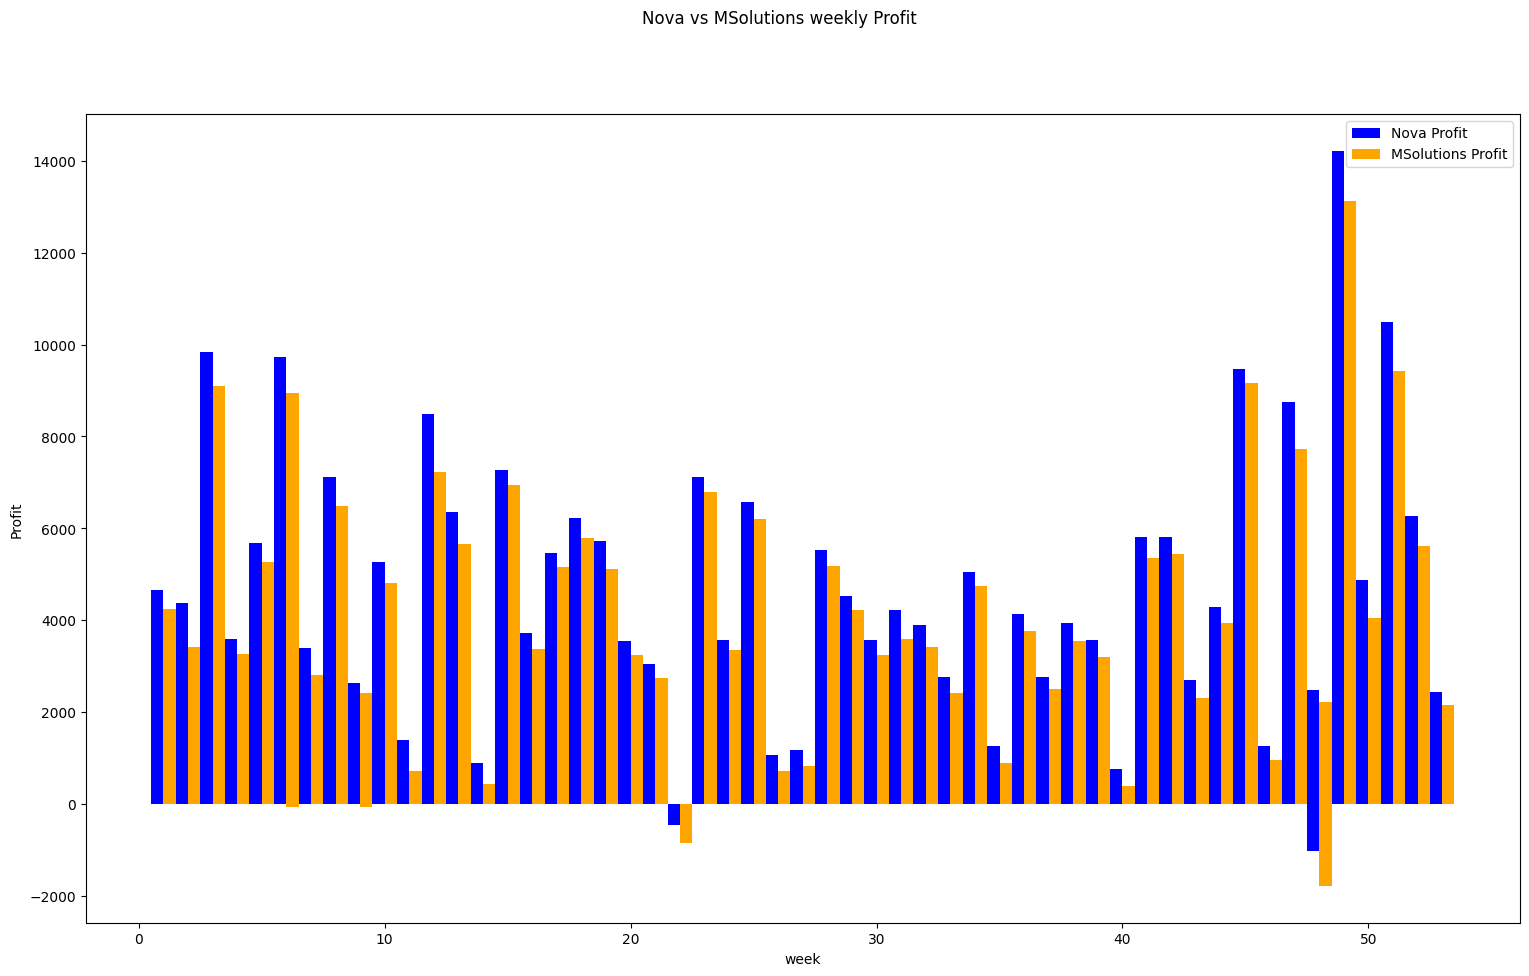

In [298]:
fig, ax = plt.subplots()
width = 0.5

# convert the index to an integer
profit_df_weekly['week'] = profit_df_weekly.index.isocalendar().week
# add a column for the week name
profit_df_weekly['week_name'] = profit_df_weekly.index.strftime('%U')
# convert the week_name to an integer
profit_df_weekly['week_name'] = profit_df_weekly['week_name'].astype(int)
# profit_df_weekly

# Nova Profit
ax.bar(profit_df_weekly.week_name - width/2, profit_df_weekly['nova_profit'], label='Nova Profit', color='blue', width=width)

# MSolutions Profit
ax.bar(profit_df_weekly.week_name + width/2, profit_df_weekly['msolutions_profit'], label='MSolutions Profit', color='orange', width=width)

# Nova Profit Input
# ax.bar(profit_df_weekly.week + width/8, profit_df_weekly['nova_profit_inp'], label='Nova Profit Inp', color='green', width=width/4)

# # MSolutions Profit Input
# ax.bar(profit_df_weekly.week + width/2.5, profit_df_weekly['msolutions_profit_inp'], label='MSolutions Profit Inp', color='red', width=width/4)

# set the x axis to be the week name
# ax.set_xticks(profit_df_weekly.week_name)

ax.set_xlabel('week')
ax.set_ylabel('Profit')
fig.suptitle('Nova vs MSolutions weekly Profit')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()


In [299]:
# what is the median of nova_profit
nova_median = profit_df_weekly['nova_profit'].median()
print('Nova Median: ', nova_median)
# what is the average
nova_mean = profit_df_weekly['nova_profit'].mean()
print('Nova Mean: ', nova_mean)

Nova Median:  3900.0368464546927
Nova Mean:  4204.34207613422


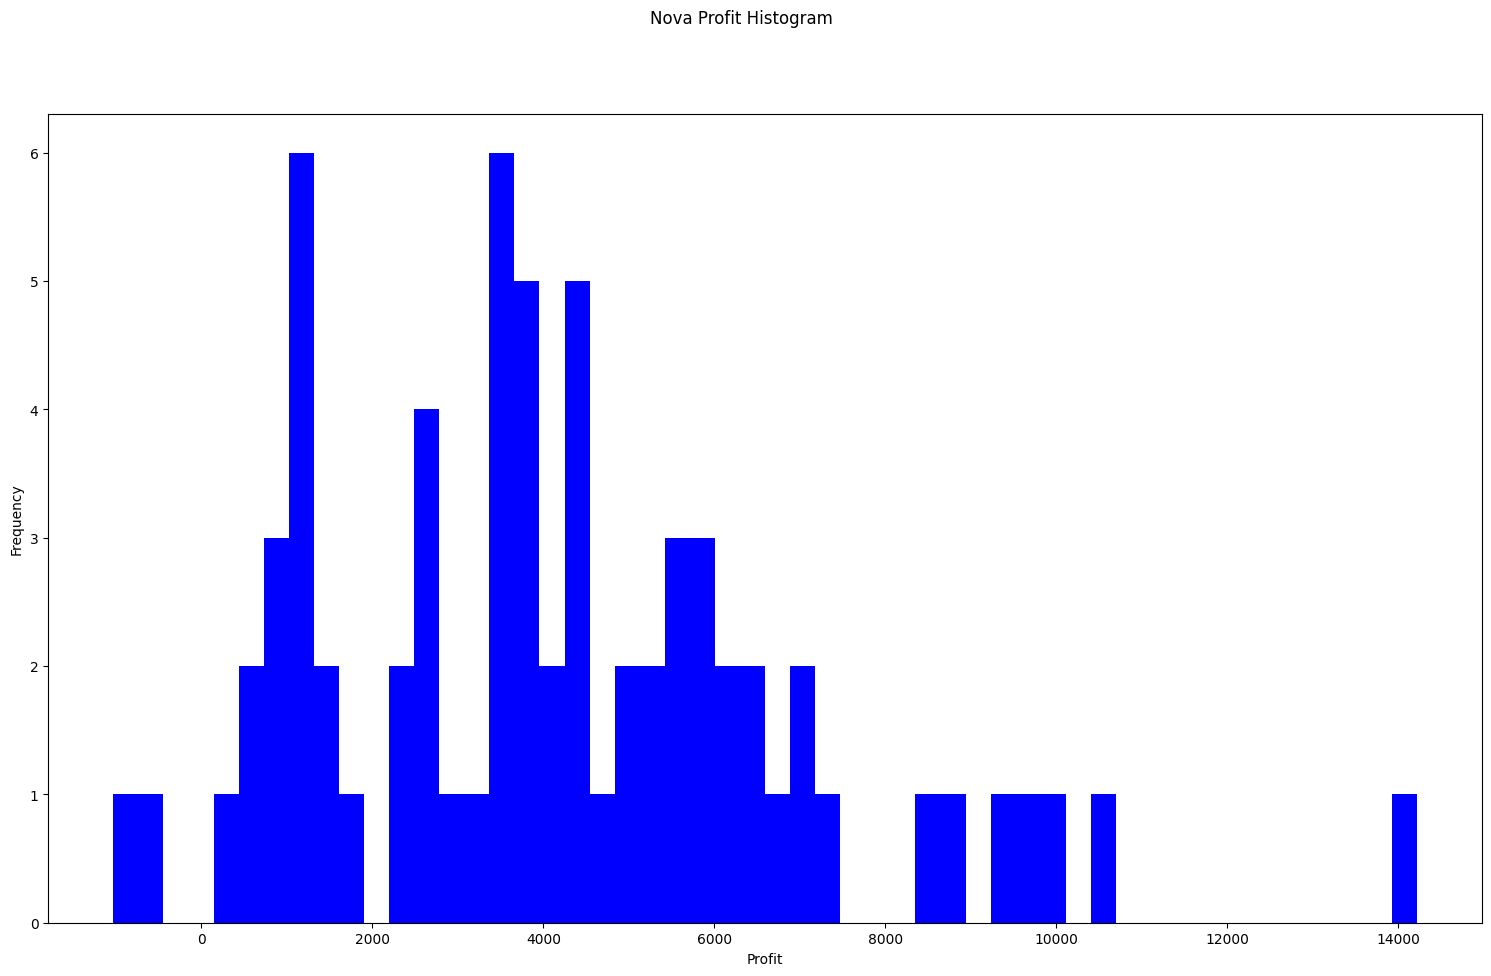

In [300]:
# create a histogram of the nova_profit for each week
fig, ax = plt.subplots()
ax.hist(profit_df_weekly['nova_profit'], bins=52, color='blue')
ax.set_xlabel('Profit')
ax.set_ylabel('Frequency')
fig.suptitle('Nova Profit Histogram')
fig.set_size_inches(18.5, 10.5)
plt.show()


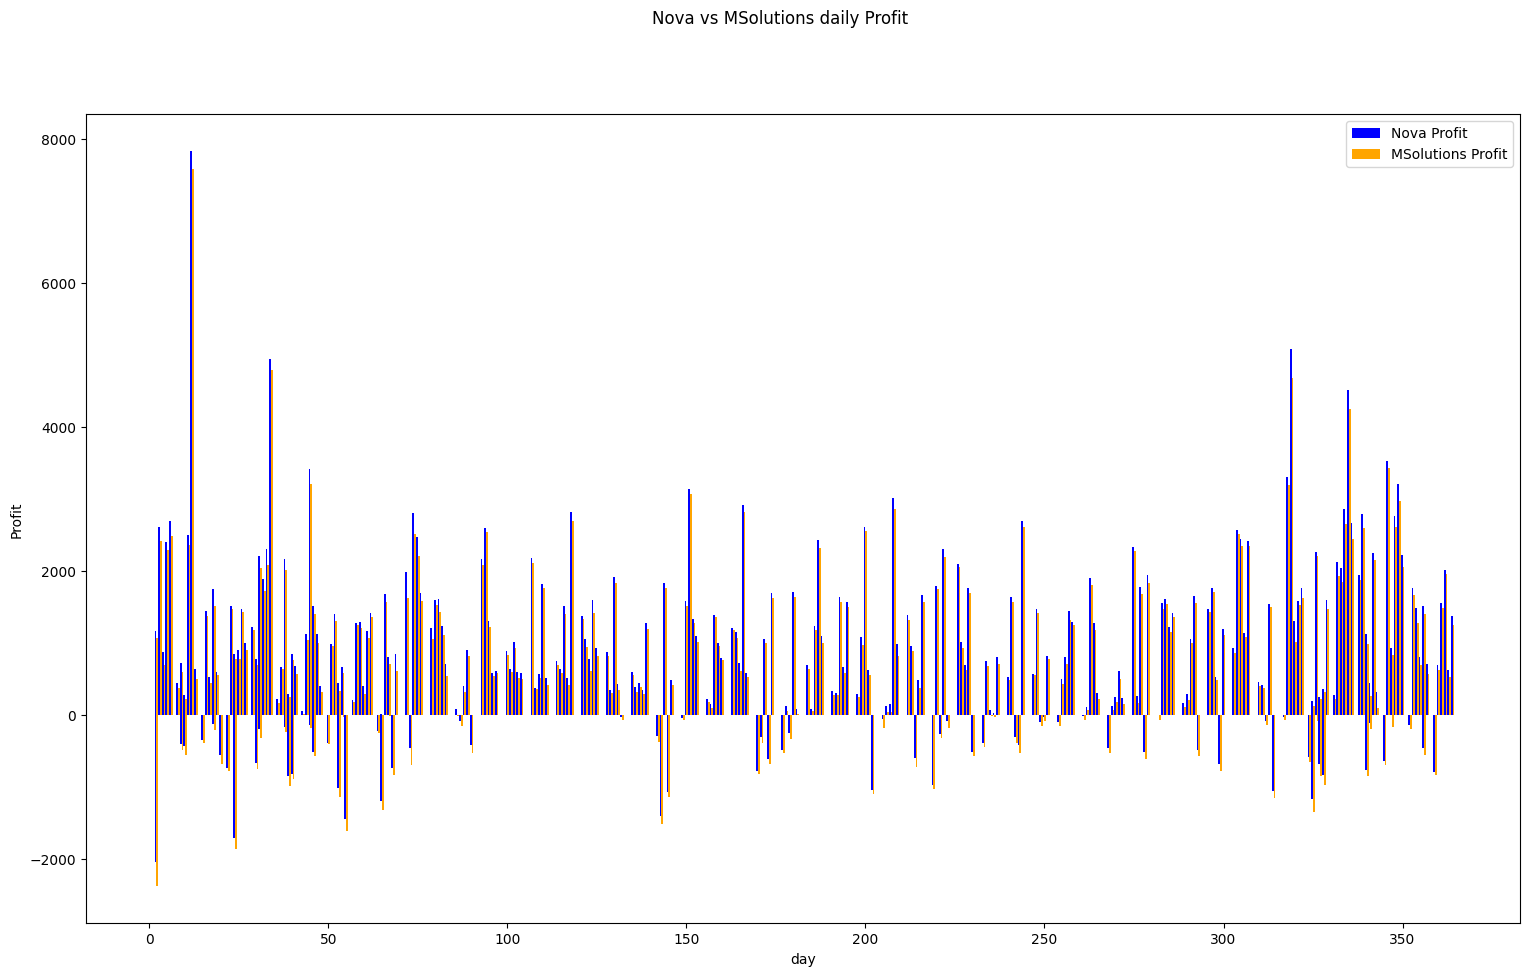

In [301]:
fig, ax = plt.subplots()
width = 0.5

# convert the index to an integer
profit_df_daily['day_number'] = profit_df_daily.index.dayofyear 
# add a column for the 
profit_df_daily['day_name'] = profit_df_daily.index.strftime('%U')
# convert the dai_name to an integer
profit_df_daily['day_name'] = profit_df_daily['day_name'].astype(int)
# profit_df_daily

# Nova Profit
ax.bar(profit_df_daily.day_number - width/2, profit_df_daily['nova_profit'], label='Nova Profit', color='blue', width=width)

# MSolutions Profit
ax.bar(profit_df_daily.day_number + width/2, profit_df_daily['msolutions_profit'], label='MSolutions Profit', color='orange', width=width)

ax.set_xlabel('day')
ax.set_ylabel('Profit')
fig.suptitle('Nova vs MSolutions daily Profit')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()


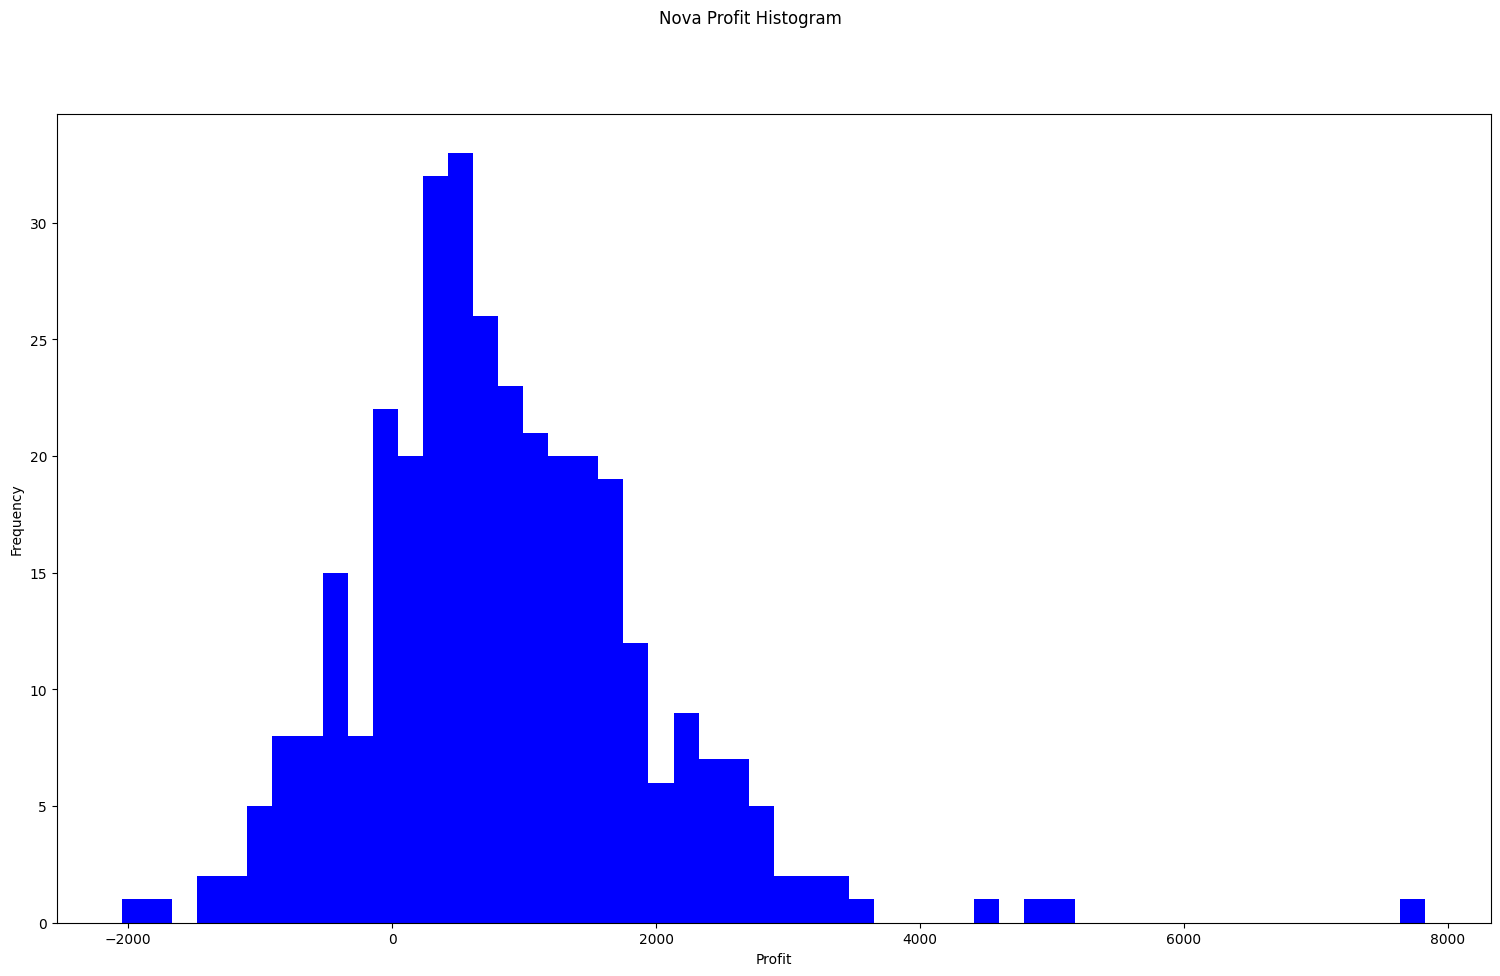

In [302]:
# create a histogram of the nova_profit for each week
fig, ax = plt.subplots()
ax.hist(profit_df_daily['nova_profit'], bins=52, color='blue')
ax.set_xlabel('Profit')
ax.set_ylabel('Frequency')
fig.suptitle('Nova Profit Histogram')
fig.set_size_inches(18.5, 10.5)
plt.show()


In [303]:
# show the bins and counts from histogram in a table
nova_profit_hist = np.histogram(profit_df_daily['nova_profit'], bins=52)
# put this into a pandas dataframe
nova_profit_hist_df = pd.DataFrame({'bin': nova_profit_hist[1][:-1], 'count': nova_profit_hist[0]})
nova_profit_hist_df


,bin,count
0,-2046.862211,1
1,-1856.904954,1
2,-1666.947698,0
3,-1476.990441,2
4,-1287.033184,2
5,-1097.075928,5
6,-907.118671,8
7,-717.161415,8
8,-527.204158,15
9,-337.246901,8


In [304]:
# how many entry times were within 5 minutes of 8:30 am
# separate the hours and minutes from the entry_time column
profit_df['entry_time'] = pd.to_datetime(profit_df['entry_time'])
profit_df['entry_hour'] = profit_df['entry_time'].dt.hour
profit_df['entry_minute'] = profit_df['entry_time'].dt.minute

# if the entry_hour is 8 and the entry_minute is between 25 and 35 then add a column called 'entry_8_30' and set it to 1
profit_df['entry_8_30'] = np.where((profit_df['entry_hour'] == 8) & (profit_df['entry_minute'] >= 25) & (profit_df['entry_minute'] <= 35), 1, 0)
# find the sum of the entry_8_30 column
entry_8_30_count = profit_df['entry_8_30'].sum()
print('Entry 8:30 Count: ', entry_8_30_count)

Entry 8:30 Count:  34


## Hour distribution

In [305]:
# find the win rate grouped by entry_hour
win_rate_by_hour = profit_df.groupby('entry_hour').agg({'nova_profit': lambda x: (x > 0).sum() / x.count()})
win_rate_by_hour

,nova_profit
entry_hour,
0,0.280374
1,0.339286
2,0.412281
3,0.333333
4,0.416185
5,0.392157
6,0.328571
7,0.375000
8,0.359756


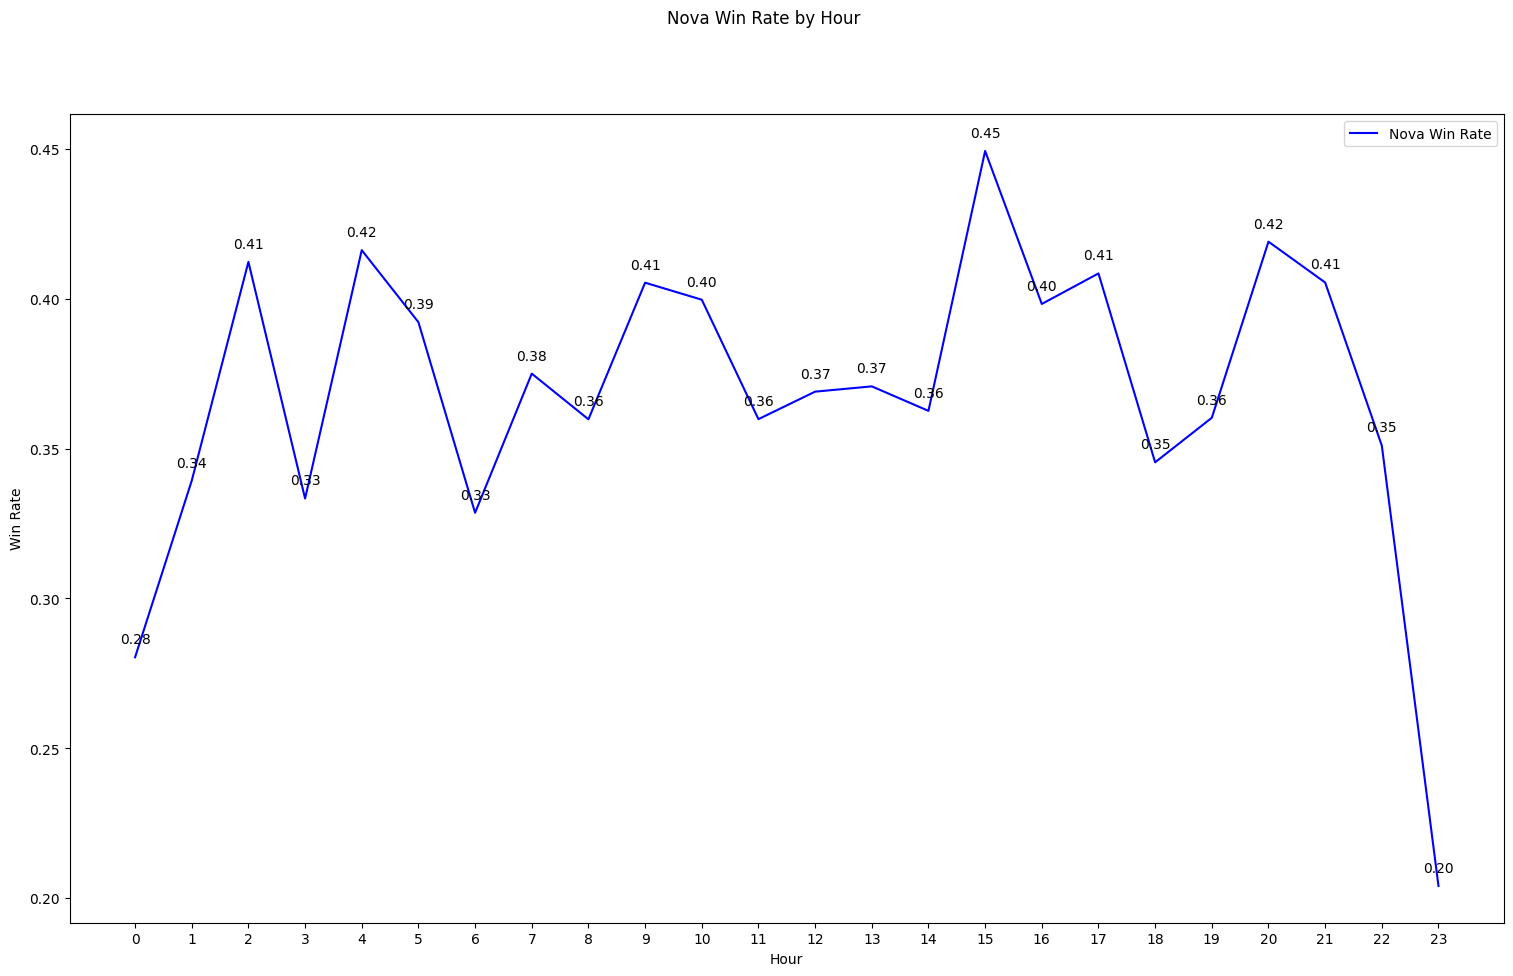

In [306]:
# create a line graph of the win rate by hour
fig, ax = plt.subplots()
ax.plot(win_rate_by_hour.index, win_rate_by_hour['nova_profit'], label='Nova Win Rate', color='blue')
# show the values for x and y next to the points
for i, txt in enumerate(win_rate_by_hour['nova_profit']):
    ax.annotate(f'{txt:.2f}', (win_rate_by_hour.index[i], win_rate_by_hour['nova_profit'][i]), textcoords="offset points", xytext=(0,10), ha='center')
# show all of the ticks on the x axis
ax.set_xticks(win_rate_by_hour.index)
ax.set_xlabel('Hour')
ax.set_ylabel('Win Rate')
fig.suptitle('Nova Win Rate by Hour')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()


In [309]:
# filter out any rows that have entry_hour as 
low_win_perc_hrs = [0,23] #20, 21,
low_win_perc_removed = profit_df[~profit_df.entry_hour.isin(low_win_perc_hrs)]
# find the sum of nova profit for low_win_perc_removed
print(low_win_perc_removed['nova_profit'].sum(), profit_df['nova_profit'].sum())
# 450,269.5324621328 436,764.53246210545 (0,7,22,23)
# 447,864.53246212745 436,764.53246210545 - nighttime hours (0,22,23)


290915.6032532614 290099.6032532612


In [308]:
# export the profit_df to a csv
# profit_df.to_csv('profit_df.csv')